<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : Ali Ghasemzadeh
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 401106339

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [1]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [2]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

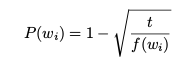

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [4]:
def preprocess_text(text):
  # Step 1: Replace punctuation with tokens to standardize the text for processing
  # Example: Replace '.', ',', and other punctuation marks with specific tokens
  text = text.replace('.', ' . ').replace(',', ' , ').replace('!', ' ! ').replace('?', ' ? ')
  text = text.replace(';', ' ; ').replace(':', ' : ').replace('(', ' ( ').replace(')', ' ) ')
  # Step 2: Convert text to lowercase and remove unnecessary whitespaces
  # Example: Apply text.lower() and text.strip()
  text = text.lower().strip()
  words = text.split()
  # Step 3: Remove stopwords from the text
  # Example: Filter out common words such as 'the', 'and', 'of' using a predefined stopwords list
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]
  # Step 4: Remove words with frequency less than 5
  # Example: Count word frequencies and filter words appearing fewer than 5 times
  word_counts = Counter(words)
  words = [word for word in words if word_counts[word] >= 5]
  # Step 5: Subsample words using a threshold value (e.g., 1e-5)
  # Example: Implement the subsampling heuristic to reduce the frequency of overly common words
  threshold = 1e-5
  total_count = sum(word_counts.values())
  word_frequencies = {word: count / total_count for word, count in word_counts.items()}
  # Return the processed words and word counts
  def subsample(word):
    frequency = word_frequencies[word]
    prob = (math.sqrt(frequency / threshold) + 1) * (threshold / frequency)
    return random.random() < prob
    
  words = [word for word in words if subsample(word)]
  return words, word_counts

It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [5]:
# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)
# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)
preprocessed_words, word_counts = preprocess_text(wiki)
sample_slice = preprocessed_words[1500:1550]
print("Sample slice of preprocessed words (index 1500 to 1550):")
print(sample_slice)

Sample slice of preprocessed words (index 1500 to 1550):
['disobedience', 'abacus', 'insurrectionary', 'anarchism', 'anarchism', 'anarchism', 'term', 'unconnected', 'contexts', 'dave', 'neal', 'posited', 'big', 'anarchism', 'anarchism', 'ideology', 'methodology', 'anarchism', 'referred', 'ideological', 'anarchists', 'anarchism', 'applied', 'methodological', 'counterparts', 'viewed', 'anarchism', 'acting', 'tendency', 'illegitimate', 'anti', 'ideological', 'anarchism', 'shares', 'similarities', 'anarchy', 'andrej', 'offer', 'alternative', 'applying', 'organising', 'acting', 'manner', 'anarchist', 'principles', 'decentralisation', 'voluntary', 'aid', 'model', 'crucially']


### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [36]:
EMBEDDING_DIM = 128
BUFFER_SIZE = 1000
BATCH_SIZE = 1024
EPOCHS = 10

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [35]:
# Step 1: Initialize and fit the tokenizer on preprocessed words
# Tokenize the preprocessed words and create a vocabulary index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_words)
# Step 2: Vectorize the words using the tokenizer's word index
# Convert the preprocessed words into vectorized tokens
vocab_size = len(tokenizer.word_index) + 1
word_indices = tokenizer.texts_to_sequences([preprocessed_words])[0]
window_size = 4
# Step 3: Generate skipgram pairs and labels
# Use the skipgrams function to create (word, context) pairs with their labels
skip_grams, labels = skipgrams(
    word_indices,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=1.0  # Ratio of negative samples
)
# Step 4: Extract target and context words from the generated pairs
# Separate the target words and context words for training
targets, contexts = zip(*skip_grams)
targets = np.array(targets, dtype=np.int32)
contexts = np.array(contexts, dtype=np.int32)
labels = np.array(labels, dtype=np.int32)
# Step 5: Split the data into training and testing sets
# Define a sample size and divide the data into training and testing subsets
split_ratio = 0.8
split_index = int(len(targets) * split_ratio)
train_targets = targets[:split_index]
train_contexts = contexts[:split_index]
train_labels = labels[:split_index]
test_targets = targets[split_index:]
test_contexts = contexts[split_index:]
test_labels = labels[split_index:]
# Step 6: Create TensorFlow datasets
# Prepare TensorFlow datasets for training and testing with appropriate batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices(((train_targets, train_contexts), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_targets, test_contexts), test_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [37]:
# Print the number of batches in the training and testing datasets
train_batches = len(train_dataset)
test_batches = len(test_dataset)

print(f"Number of batches in the training dataset: {train_batches}")
print(f"Number of batches in the testing dataset: {test_batches}")

Number of batches in the training dataset: 14507
Number of batches in the testing dataset: 3627


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [38]:
# Step 1: Create a custom model class by subclassing `tf.keras.Model`
# Define a class that inherits from the Keras Model class

# Step 2: Initialize the layers in the `__init__` method
# Define all the layers such as embedding, dense, or output layers

# Step 3: Implement the forward pass in the `call` method
# Define how the input data flows through the model to produce the output

# Step 4: Ensure the model implements the skip-gram architecture
# Include logic for embedding lookups and processing positive and negative samples

# Step 5: Verify that the model structure aligns with the objective
# Test the forward pass to ensure proper layer connections and outputs
import tensorflow as tf

# Step 1: Create a custom model class by subclassing `tf.keras.Model`
class Word2VecModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecModel, self).__init__()
        
        # Step 2: Initialize the layers
        # Embedding layer for word vectors
        self.target_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name="target_embedding"
        )
        self.context_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name="context_embedding"
        )
        # Dense layer for computing dot product between embeddings
        self.dot_product = tf.keras.layers.Dot(axes=-1, normalize=False, name="dot_product")

    # Step 3: Implement the forward pass in the `call` method
    def call(self, inputs):
        target, context = inputs  # Unpack inputs (target, context)
        
        # Get embeddings for target and context words
        target_vector = self.target_embedding(target)
        context_vector = self.context_embedding(context)
        
        # Compute dot product of the embeddings
        dot_product = self.dot_product([target_vector, context_vector])
        
        # Apply sigmoid activation to get probabilities
        output = tf.keras.activations.sigmoid(dot_product)
        
        return output

# Step 4: Instantiate and test the model
# Define hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = EMBEDDING_DIM

# Initialize the model
word2vec_model = Word2VecModel(vocab_size, embedding_dim)

# Test the forward pass with dummy data
dummy_target = tf.constant([1, 2, 3])  # Example target word indices
dummy_context = tf.constant([4, 5, 6])  # Example context word indices
dummy_output = word2vec_model((dummy_target, dummy_context))

print("Output of the model (sample predictions):")
print(dummy_output)


Output of the model (sample predictions):
tf.Tensor(
[[0.5011479 ]
 [0.49566585]
 [0.5003732 ]], shape=(3, 1), dtype=float32)


### Loss function, Metrics and Optimizers

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_acc_metric = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="val_accuracy")

### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [42]:
import time

# Step 1: Define the training step
@tf.function
def train_step(model, optimizer, loss_fn, train_acc_metric, targets, contexts, labels):
    with tf.GradientTape() as tape:
        predictions = model((targets, contexts), training=True)  # Forward pass
        loss = loss_fn(labels, predictions)  # Compute loss
    gradients = tape.gradient(loss, model.trainable_weights)  # Compute gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))  # Apply gradients
    train_acc_metric.update_state(labels, predictions)  # Update training accuracy metric
    return loss

# Step 2: Define the testing step
@tf.function
def test_step(model, loss_fn, val_acc_metric, targets, contexts, labels):
    predictions = model((targets, contexts), training=False)  # Forward pass
    loss = loss_fn(labels, predictions)  # Compute validation loss
    val_acc_metric.update_state(labels, predictions)  # Update validation accuracy metric
    return loss

# Step 3: Initialize the training loop
for epoch in range(EPOCHS):
    print(f"\nStarting epoch: {epoch}")
    start_time = time.time()

    # Training phase
    train_loss = 0.0
    for batch, ((targets, contexts), labels) in enumerate(train_dataset):
        # if batch  == 1000:
        #     break
        batch_loss = train_step(word2vec_model, optimizer, loss_fn, train_acc_metric, targets, contexts, labels)
        train_loss += batch_loss

    # Compute cumulative training loss and accuracy
    train_acc = train_acc_metric.result().numpy()
    train_acc_metric.reset_state()  # Updated to reset_state()

    # Validation phase
    val_loss = 0.0
    for batch, ((targets, contexts), labels) in enumerate(test_dataset):
        batch_loss = test_step(word2vec_model, loss_fn, val_acc_metric, targets, contexts, labels)
        val_loss += batch_loss

    # Compute cumulative validation loss and accuracy
    val_acc = val_acc_metric.result().numpy()
    val_acc_metric.reset_state()  # Updated to reset_state()

    # Log epoch metrics
    print(f"Training acc over epoch: {train_acc:.4f}")
    print(f"Cummulative loss: {train_loss.numpy():.4f}")
    print(f"Validation acc over epoch: {val_acc:.4f}")
    print(f"Cummulative test loss: {val_loss.numpy():.4f}")
    print(f"Time taken: {time.time() - start_time:.2f}s")



Starting epoch: 0
Training acc over epoch: 0.8137
Cummulative loss: 6256.3340
Validation acc over epoch: 0.8197
Cummulative test loss: 1499.7494
Time taken: 203.15s

Starting epoch: 1
Training acc over epoch: 0.8483
Cummulative loss: 5126.5068
Validation acc over epoch: 0.8276
Cummulative test loss: 1444.9926
Time taken: 200.39s

Starting epoch: 2
Training acc over epoch: 0.8672
Cummulative loss: 4547.9907
Validation acc over epoch: 0.8278
Cummulative test loss: 1463.2664
Time taken: 201.64s

Starting epoch: 3
Training acc over epoch: 0.8800
Cummulative loss: 4167.8555
Validation acc over epoch: 0.8258
Cummulative test loss: 1511.9938
Time taken: 201.55s

Starting epoch: 4
Training acc over epoch: 0.8889
Cummulative loss: 3903.1345
Validation acc over epoch: 0.8233
Cummulative test loss: 1573.3611
Time taken: 201.20s


In [43]:
# Save weights to a Tensorflow Checkpoint file
# Define a checkpoint manager
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=word2vec_model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory="./checkpoints", max_to_keep=3)

# Save the weights
checkpoint_manager.save()
print("Model weights saved to checkpoint.")


Model weights saved to checkpoint.


### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [44]:
import os
import numpy as np

# Step 1: Access the embedding layer from the trained model
embedding_layer = word2vec_model.target_embedding

# Step 2: Extract the weights from the embedding layer
embedding_weights = embedding_layer.get_weights()[0]  # Get the weights as a NumPy array

# Define file paths for saving the embeddings and metadata
output_dir = "./embeddings_projector"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
vecs_file = os.path.join(output_dir, "vecs.tsv")
meta_file = os.path.join(output_dir, "meta.tsv")

# Step 3: Open files to store embeddings and metadata
with open(vecs_file, "w", encoding="utf-8") as vecs, open(meta_file, "w", encoding="utf-8") as meta:
    # Step 4: Iterate through the tokenizer's vocabulary
    for word, index in tokenizer.word_index.items():
        if index >= len(embedding_weights):
            continue  # Skip words outside the vocabulary size
        embedding_vector = embedding_weights[index]
        vecs.write("\t".join([str(x) for x in embedding_vector]) + "\n")  # Write vector to vecs.tsv
        meta.write(word + "\n")  # Write word to meta.tsv

# Step 5: Close the files after writing
print(f"Embedding vectors saved to {vecs_file}")
print(f"Metadata saved to {meta_file}")


Embedding vectors saved to ./embeddings_projector/vecs.tsv
Metadata saved to ./embeddings_projector/meta.tsv


In [45]:
# Access the embedding layer from the trained model
embedding_layer = word2vec_model.target_embedding

# Extract the embedding weights
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape of the embedding weights
print(f"Shape of word embeddings: {embedding_weights.shape}")


Shape of word embeddings: (71141, 128)


### since the size of the vecs.csv file was large i can't upload it in quera so you can download it from this link :<br>
- https://s32.picofile.com/file/8481854968/vecs.tsv.html